In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
from collections import defaultdict


%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../survey_ops/utils')
from ephemerides import get_source_ra_dec, equatorial_to_topographic, topographic_to_equatorial
from geometry import angular_separation
from units import *

sys.path.append('../survey_ops/src')
import environments
from offline_dataset import TelescopeDatasetv0
from agents import Agent
from algorithms import DDQN, BehaviorCloning

In [3]:
from pytorch_utils import seed_everything
seed_everything(10)

# Load and preprocess data

In [4]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


In [5]:
# Get repeat field info

# via collections
# from collections import Counter
# counts = Counter(zip(_df['ra'], _df['dec']))

# via pandas
# a = _df.groupby(['ra','dec'])

In [9]:
class OfflineDataset(torch.utils.data.Dataset):
    def __init__(self, df, state_vars=None, num_bins_1d=10):
        # save timestamps to df
        utc = pd.to_datetime(df['datetime'], utc=True)
        timestamps = (utc.astype('int64') // 10**9).values
        df['timestamps'] = timestamps
        
        # Get DataFrames grouped by night, sorted chronologically
        df = df.set_index('datetime')
        df = df[df.index.year != 1970]
        df['date'] = df.index.date
        self._df = df
        self.n_obs_tot = len(df)

        # ensure all data are 32-bit precision before training
        for str_bit, np_bit in zip(['float64', 'int64'], [np.float32, np.int32]): 
            cols = df.select_dtypes(include=[str_bit]).columns
            df[cols] = df[cols].astype(np_bit)
            
        groups = df.groupby(df.index.normalize())
        self._groups = groups
        self.unique_nights = groups.groups.keys()
        self.n_nights = groups.ngroups
        self.n_obs_per_night = groups.size() # nights have different numbers of observations
        
        self.state_vars = ['az', 'el', 'sun_pos', 'moon_pos', 'air_mass', 'ha'] if state_vars is None else state_vars
        self.states, self.next_states = self._construct_states(df, groups)
        self.num_transitions = len(self.states)
        self.actions, self.num_actions = self._construct_actions(num_bins_1d)
        self.rewards = self._construct_rewards(groups)
        self.dones = np.zeros(self.num_transitions, dtype=bool) # False unless last observation of the night
        self._done_indices = np.where(self.states[:, 0] == -1)[0][1:] - 1
        self.dones[self._done_indices] = True
        self.action_masks = self._construct_action_masks()

    def __len__(self):
        return len(self.transitions)

    def __getitem__(self, idx):
        transition = (
            self.states[idx],
            self.actions[idx],
            self.rewards[idx],
            self.next_states[idx],
            self.dones[idx],
            self.action_mask[idx]
        )
        return transition

    def _construct_states(self, df, groups):
        
        az = -1 * np.ones(shape=(self.n_obs_tot + self.n_nights), dtype=np.float32) # need to add plus 1 for the null observation each night
        el = -1 * np.ones_like(az, dtype=np.float32)
        sun_az = -1 * np.ones_like(az, dtype=np.float32)
        sun_el = -1 * np.ones_like(az, dtype=np.float32)
        moon_az = -1 * np.ones_like(az, dtype=np.float32)
        moon_el = -1 * np.ones_like(az, dtype=np.float32)
        airmass = -1 * np.ones_like(az, dtype=np.float32)
        ha = -1 * np.ones_like(az, dtype=np.float32)
        null_obs_indices = []
        
        for i, ((day, subdf), (_, idxs)) in enumerate(zip(groups, groups.indices.items())):
            indices = idxs + i + 1
            null_obs_indices.append(idxs[0] + i)
            timestamps = subdf['timestamps']
            az[indices] = subdf['az'].values
            el[indices] = 90.0 - subdf['zd'].values
            airmass[indices] = subdf['airmass'].values
            ha[indices] = subdf['ha'].values
            
            # Get sun and moon az&el
            for idx, time in zip(indices, timestamps):
                sun_ra, sun_dec = get_source_ra_dec('sun', time=time)
                moon_ra, moon_dec = get_source_ra_dec('moon', time=time)
                sun_az[idx], sun_el[idx] = equatorial_to_topographic(ra=sun_ra, dec=sun_dec, time=time)
                moon_az[idx], moon_el[idx] = equatorial_to_topographic(ra=moon_ra, dec=moon_dec, time=time)
                
        self.az = az
        self.el = el
        self.sun_az = sun_az
        self.sun_el = sun_el
        self.moon_az = moon_az
        self.moon_el = moon_el
        self.airmass = airmass
        self.ha = ha
        self.null_obs_indices = np.array(null_obs_indices, dtype=np.int32)
        self.null_mask = np.ones_like(self.az, dtype=bool)
        self.null_mask[self.null_obs_indices] = False
        all_states = np.vstack((az, el, sun_az, sun_el, moon_az, moon_el, airmass, ha)).T
        self._all_states = all_states
        states = np.delete(all_states, self.null_obs_indices[1:] - 1, axis=0)[:-1]
        next_states = np.delete(all_states, self.null_obs_indices, axis=0)
        return states, next_states

    def _construct_actions(self, num_bins_1d):
        az_edges = np.linspace(0, 360, num_bins_1d + 1, dtype=np.float32)
        # az_centers = az_edges[:-1] + (az_edges[1] - az_edges[0])/2
        el_edges = np.linspace(27, 90, num_bins_1d + 1, dtype=np.float32)
        # az_centers = el_edges[:-1] + (el_edges[1] - el_edges[0])/2

        i_x = np.digitize(self.next_states[:, 0], az_edges).astype(np.int32) - 1
        i_y = np.digitize(self.next_states[:, 1], el_edges).astype(np.int32) - 1
        bin_ids = i_x * (num_bins_1d) + i_y
        num_bins = int(num_bins_1d * num_bins_1d)
        self.az_edges = az_edges
        self.el_edges = el_edges
        
        id2azel = defaultdict(list)
        id2bincoord = defaultdict(list)
        for az, el, bin_id in zip(self.next_states[:, 0], self.next_states[:, 1], bin_ids):
            id2azel[bin_id].append((az, el))
            
        id2azel = dict(sorted(id2azel.items()))
        self.id2azel = id2azel
        return bin_ids, num_bins

    def _construct_rewards(self, groups):
        rewards = np.ones(len(self.states))
        for ((day, subdf), (_, idxs)) in zip(groups, groups.indices.items()):
            rewards[idxs] = subdf['teff']
        return rewards

    def _construct_action_masks(self):
        return np.ones((self.num_transitions, self.num_actions), dtype=bool)


In [16]:
num_bins_1d = 19
dataset = OfflineDataset(df, num_bins_1d=num_bins_1d)

Text(0, 0.5, 'Elevation')

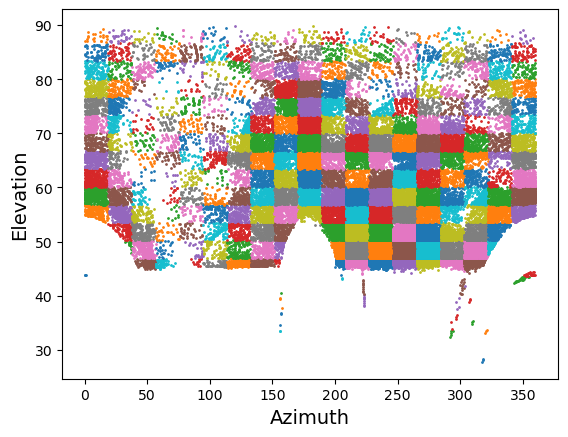

In [17]:
for bin_id in dataset.id2azel.keys():
    field_ids = np.array(dataset.id2azel[bin_id])
    
    plt.scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=1)
# plt.legend()
plt.xlabel('Azimuth', fontsize=14)
plt.ylabel('Elevation', fontsize=14)

Text(0.5, 1.0, 'number of obs per night')

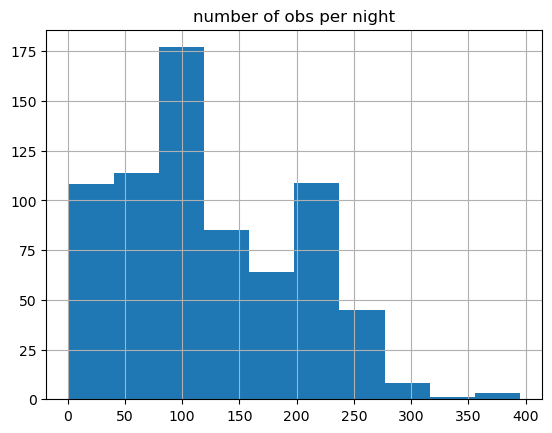

In [18]:
dataset.n_obs_per_night.hist()
plt.title('number of obs per night')

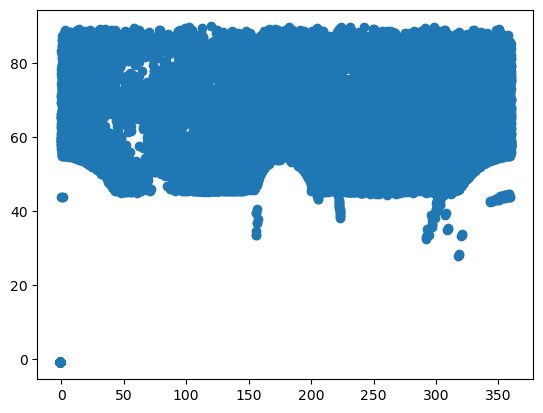

In [19]:
plt.scatter(dataset.az, dataset.el)

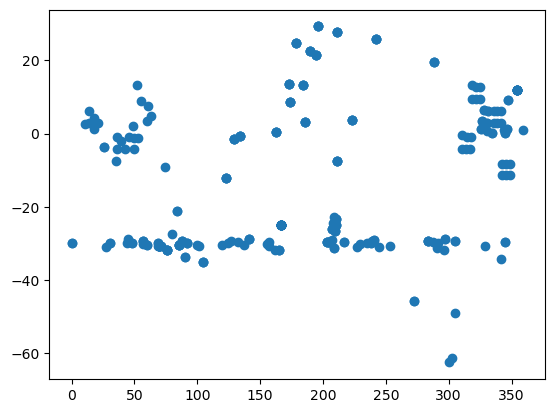

In [62]:
plt.scatter(ra, dec)

In [29]:
delve_df

NameError: name 'delve_df' is not defined

In [30]:
field_id = 10
timestamp = schedule.iloc[field_id].time
field_ra, field_dec = id2pos[field_id]
field_az, field_el = ephemerides.equatorial_to_topographic(field_ra, field_dec, time=timestamp)
sun_ra, sun_dec = ephemerides.get_source_ra_dec("sun", time=timestamp)
sun_az, sun_el = ephemerides.equatorial_to_topographic(sun_ra, sun_dec, time=timestamp)
moon_ra, moon_dec = ephemerides.get_source_ra_dec("moon", time=timestamp)
moon_az, moon_el = ephemerides.equatorial_to_topographic(moon_ra, moon_dec, time=timestamp)

NameError: name 'schedule' is not defined

# Visualize schedule

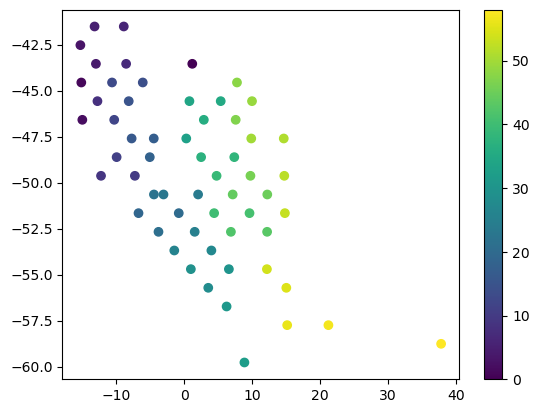

In [12]:

radec = np.array([id2pos[field_id] for field_id in schedule.field_id.values])
ra_shifted = np.where(radec[:, 0] > 180, radec[:, 0] - 360, radec[:, 0])
c = plt.scatter(ra_shifted, radec[:, 1], c = np.arange(len(ra_shifted)))
plt.colorbar(c)

# Configure dataset, model, and training setup

In [13]:
SEED = 10
train_size = 1


seed_everything(SEED)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [14]:
dataset = TelescopeDatasetv0(schedule, id2pos, normalize_obs=True)

In [15]:
np.prod(dataset.obs.shape[1:])

58

In [16]:
"""DESIRED Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 1e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 3000,
    'batch_size': 32,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):

    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_unique={dataset._nfields}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)


agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_obs,
    'outdir': outdir
    }

agent = Agent(**agent_config)



In [17]:
from environments import TelescopeEnv_v0

env_name = 'TelescopeEnv-v0'

gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=TelescopeEnv_v0,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'dataset': dataset
}


env = gym.make(**env_config)
# Create multiple environments for parallel training
# vec_env = gym.make_vec("gymnasium_env/SimpleTel-v0", num_envs=5, vectorization_mode='sync', Nf=Nf, target_sequence=true_sequence, nv_max=nv_max)

from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


# Train

In [18]:
start_time = time.time()
"""Train"""
agent.fit(
    dataset,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(train_time)

  0%|          | 0/5437 [00:00<?, ?it/s]

  5%|▍         | 255/5437 [00:00<00:04, 1285.83it/s]

Train step 0: Accuracy = 0.062, Loss = 4.0616
Train step 100: Accuracy = 0.219, Loss = 3.7820
Train step 200: Accuracy = 0.344, Loss = 2.7733


  9%|▉         | 516/5437 [00:00<00:03, 1232.06it/s]

Train step 300: Accuracy = 0.625, Loss = 2.2556
Train step 400: Accuracy = 0.750, Loss = 1.8546
Train step 500: Accuracy = 0.688, Loss = 1.5163


 14%|█▍        | 786/5437 [00:00<00:03, 1295.72it/s]

Train step 600: Accuracy = 0.750, Loss = 1.3181
Train step 700: Accuracy = 0.875, Loss = 1.2112
Train step 800: Accuracy = 0.844, Loss = 1.0425


 19%|█▉        | 1056/5437 [00:00<00:03, 1320.72it/s]

Train step 900: Accuracy = 0.906, Loss = 0.6930
Train step 1000: Accuracy = 0.938, Loss = 0.8171
Train step 1100: Accuracy = 0.969, Loss = 0.6116


 27%|██▋       | 1465/5437 [00:01<00:02, 1351.48it/s]

Train step 1200: Accuracy = 0.938, Loss = 0.5906
Train step 1300: Accuracy = 0.750, Loss = 0.5102
Train step 1400: Accuracy = 0.969, Loss = 0.5112


 32%|███▏      | 1737/5437 [00:01<00:02, 1348.76it/s]

Train step 1500: Accuracy = 0.938, Loss = 0.3982
Train step 1600: Accuracy = 0.906, Loss = 0.4445
Train step 1700: Accuracy = 1.000, Loss = 0.4334


 37%|███▋      | 2007/5437 [00:01<00:02, 1330.34it/s]

Train step 1800: Accuracy = 1.000, Loss = 0.3623
Train step 1900: Accuracy = 0.938, Loss = 0.2990
Train step 2000: Accuracy = 1.000, Loss = 0.2385


 42%|████▏     | 2278/5437 [00:01<00:02, 1339.08it/s]

Train step 2100: Accuracy = 0.906, Loss = 0.2242
Train step 2200: Accuracy = 1.000, Loss = 0.3323
Train step 2300: Accuracy = 1.000, Loss = 0.2507


 47%|████▋     | 2550/5437 [00:01<00:02, 1285.23it/s]

Train step 2400: Accuracy = 1.000, Loss = 0.2416
Train step 2500: Accuracy = 1.000, Loss = 0.1921
Train step 2600: Accuracy = 1.000, Loss = 0.2785


 54%|█████▍    | 2951/5437 [00:02<00:01, 1320.08it/s]

Train step 2700: Accuracy = 1.000, Loss = 0.1812
Train step 2800: Accuracy = 0.938, Loss = 0.2587
Train step 2900: Accuracy = 1.000, Loss = 0.1725


 59%|█████▉    | 3217/5437 [00:02<00:01, 1317.20it/s]

Train step 3000: Accuracy = 1.000, Loss = 0.0960
Train step 3100: Accuracy = 0.969, Loss = 0.1392
Train step 3200: Accuracy = 1.000, Loss = 0.0936


 64%|██████▍   | 3485/5437 [00:02<00:01, 1329.66it/s]

Train step 3300: Accuracy = 0.938, Loss = 0.1207
Train step 3400: Accuracy = 1.000, Loss = 0.0349
Train step 3500: Accuracy = 0.969, Loss = 0.2402


 69%|██████▉   | 3753/5437 [00:02<00:01, 1331.62it/s]

Train step 3600: Accuracy = 1.000, Loss = 0.0965
Train step 3700: Accuracy = 1.000, Loss = 0.1345
Train step 3800: Accuracy = 1.000, Loss = 0.0841


 77%|███████▋  | 4173/5437 [00:03<00:00, 1379.80it/s]

Train step 3900: Accuracy = 1.000, Loss = 0.1194
Train step 4000: Accuracy = 1.000, Loss = 0.0908
Train step 4100: Accuracy = 1.000, Loss = 0.1418


 82%|████████▏ | 4449/5437 [00:03<00:00, 1369.53it/s]

Train step 4200: Accuracy = 1.000, Loss = 0.1082
Train step 4300: Accuracy = 1.000, Loss = 0.1307
Train step 4400: Accuracy = 1.000, Loss = 0.0795


 87%|████████▋ | 4722/5437 [00:03<00:00, 1330.83it/s]

Train step 4500: Accuracy = 1.000, Loss = 0.0525
Train step 4600: Accuracy = 1.000, Loss = 0.0911
Train step 4700: Accuracy = 1.000, Loss = 0.0588


 92%|█████████▏| 4992/5437 [00:03<00:00, 1330.84it/s]

Train step 4800: Accuracy = 1.000, Loss = 0.0366
Train step 4900: Accuracy = 1.000, Loss = 0.0355
Train step 5000: Accuracy = 1.000, Loss = 0.0665


 97%|█████████▋| 5259/5437 [00:03<00:00, 1327.14it/s]

Train step 5100: Accuracy = 1.000, Loss = 0.0358
Train step 5200: Accuracy = 1.000, Loss = 0.0759
Train step 5300: Accuracy = 1.000, Loss = 0.0354


100%|██████████| 5437/5437 [00:04<00:00, 1323.72it/s]

Train step 5400: Accuracy = 1.000, Loss = 0.0569
4.112272024154663


In [19]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

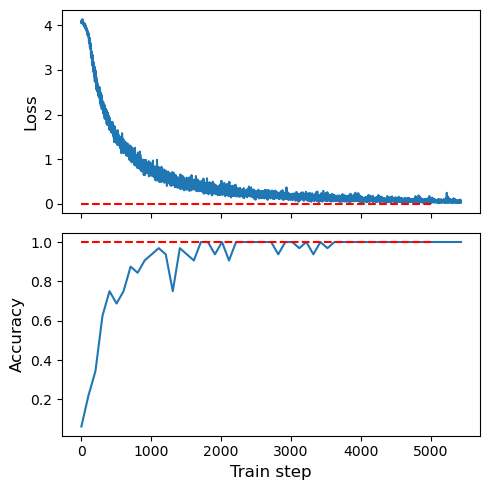

In [20]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=5000, color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=12)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=5000, color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].set_xlabel('Train step', fontsize=12)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [22]:
agent.evaluate(env=env, num_episodes=1)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

100%|██████████| 1/1 [00:00<00:00, 90.72it/s]

terminated at 58
eval_metrics.pkl saved in ../results/None/


/tmp/ipykernel_17254/76053858.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


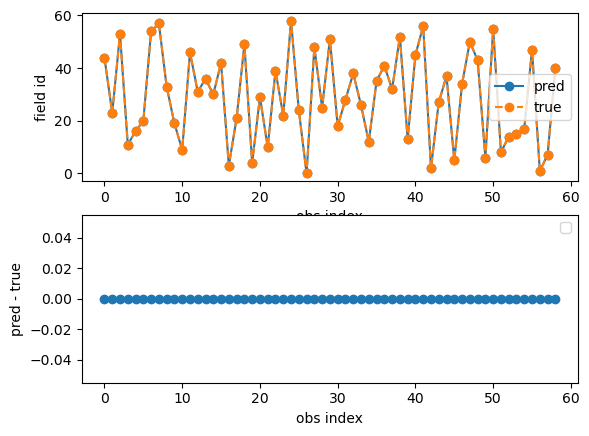

In [23]:
target_sequence = dataset._schedule_field_ids[0]
eval_sequence = eval_metrics['observations']['ep-0'][:, 0]

fig, axs = plt.subplots(2)
axs[0].plot(eval_sequence, marker='o', label='pred')
axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true')
axs[0].legend()
axs[0].set_xlabel('obs index')
axs[0].set_ylabel('field id')

axs[1].plot(eval_sequence - target_sequence, marker='o')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')


fig.savefig(outdir + 'learned_sequence.png')